In [1]:
import os
import threadpoolctl
import warnings
from pathlib import Path
import re

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as pl
from sklearn.metrics import roc_auc_score

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity, HitRate
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

/Users/aleksandryusov/.pyenv/versions/base/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Data

In [2]:
data_dir = Path("../data/raw/")

interactions_df = pl.read_parquet(data_dir / "train_interactions.parquet")
test_pairs = pl.read_csv(data_dir / "test_pairs.csv.csv")
items_meta_df = pl.read_parquet("../data/raw/items_meta.parquet")
users_meta_df = pl.read_parquet("../data/raw/users_meta.parquet")

## target

<Axes: xlabel='ratio_bin'>

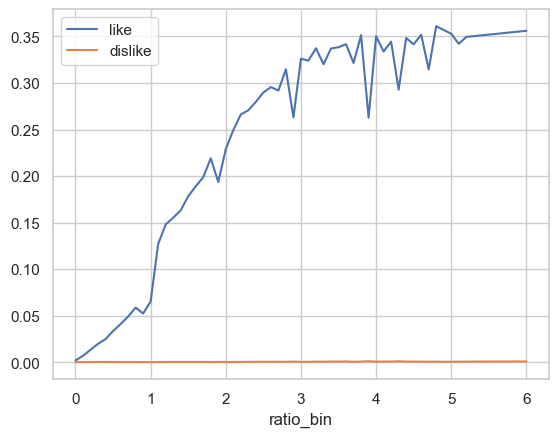

In [30]:
bin_size = 10

(
    interactions_df
    # .sample(100000)
    .lazy()
    .join(items_meta_df.lazy().select("item_id", "duration"), on="item_id", how="inner")
    .with_columns(
        pl.col("timespent").truediv("duration").alias("timespent_ratio")
    )
    .with_columns(
        ((pl.col("timespent_ratio") * 100).floordiv(bin_size) * bin_size / 100).alias("ratio_bin")
    )
    .group_by("ratio_bin")
    .agg(
        (
            pl.col("like").cast(bool)
            | pl.col("share").cast(bool)
            | pl.col("bookmarks").cast(bool)
        ).cast(int).mean(),
        pl.col("dislike").mean(),
        pl.count().alias("total")
    )
    .filter(pl.col("total") > 10000)
    .drop("total")
    .sort("ratio_bin")
    .collect()
    .to_pandas()
    .set_index("ratio_bin")
    .plot()
)

In [29]:
interactions_df = (
    interactions_df
    .filter((pl.col("like") + pl.col("dislike")) >= 1)
    .with_columns(weight=pl.col("like").cast(pl.Int8) - pl.col("dislike").cast(pl.Int8))
    .select("user_id", "item_id", pl.col("weight").alias(Columns.Weight))
)

interactions_df.sample(3)

user_id,item_id,weight
u32,u32,i8
74851,322434,1
158111,40701,1
168582,52299,1


## train/test split

In [4]:
from sklearn.model_selection import train_test_split


split_users = (
    interactions_df
    .group_by("user_id")
    .count()
    .filter(pl.col("count") > 1)
    .select("user_id")
)
interactions_df_split = interactions_df.join(split_users, how="inner", on="user_id")
train_df, test_df = train_test_split(interactions_df_split, test_size=0.2, stratify=interactions_df_split["user_id"])
train_df = train_df.with_columns(pl.lit(0).alias(Columns.Datetime))
test_df = test_df.with_columns(pl.lit(1).alias(Columns.Datetime))

# aильтр айтемов, которых нет в трейне
test_df = (
    test_df
    .join(
        train_df.select(pl.col("item_id").unique()),
        how="inner", on="item_id"
    )
)

# добавляем юзеров, у которых всего 1 взаимодействие
# train_df = pl.concat([train_df, interactions_df.join(split_users, how="anti", on="user_id")])

In [5]:
test_users = test_df["user_id"].unique().to_numpy()
catalog = interactions_df["item_id"].unique().to_numpy()

## Flatten features

## Users meta

In [6]:
users_meta_df = (
    users_meta_df
    .with_columns(
        pl.col("age").cut(list(range(10, 100, 10))).to_physical().alias("age_group"),
        # pl.col("age").cut(list(range(10, 100, 10))).alias('adsad')
    )
)

users_meta_df.sample(10)

user_id,gender,age,age_group
u32,u8,u8,u32
38782,1,29,2
126533,2,21,2
78096,2,22,2
150759,2,22,2
98168,2,25,2
106445,2,41,4
105924,1,20,1
126906,1,22,2
84481,2,24,2


In [7]:
users_meta_df_flatten = (
    users_meta_df
    .melt(id_vars=["user_id"], value_vars=["gender", "age_group"], variable_name="feature", value_name="value")
    .rename({"user_id": "id"})
)

In [8]:
users_meta_df_flatten.filter(pl.col("value").is_null())

id,feature,value
u32,str,u32


In [9]:
(
    users_meta_df_flatten
    .sample(3)
)

id,feature,value
u32,str,u32
150299,"""age_group""",2
10697,"""gender""",1
106722,"""gender""",1


<Axes: ylabel='Frequency'>

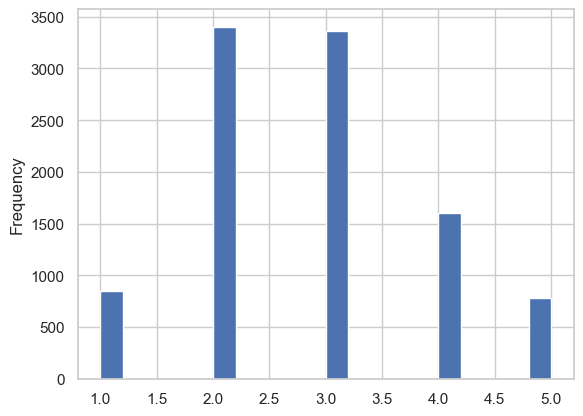

In [10]:
users_meta_df_flatten.filter(pl.col("feature") == "age_group").sample(10000)["value"].to_pandas().plot.hist(bins=20)

## Item meta

In [11]:
items_meta_df.sample(3)

item_id,source_id,duration,embeddings
u32,u32,u8,"array[f32, 32]"
205185,13102,56,"[0.411412, -0.323459, … -0.05051]"
198374,6946,18,"[0.081964, 0.136387, … -0.027898]"
235929,2599,59,"[0.18985, 0.084323, … -0.031152]"


<Axes: >

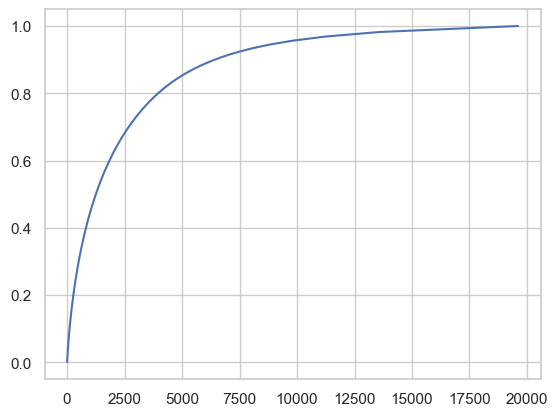

In [12]:
(
    items_meta_df["source_id"]
    .value_counts()
    .sort("count", descending=True)
    .with_columns(pl.col("count").cum_sum())
    .with_columns(pl.col("count") / pl.col("count").max())
    .to_pandas()["count"].plot()
)

<Axes: ylabel='Frequency'>

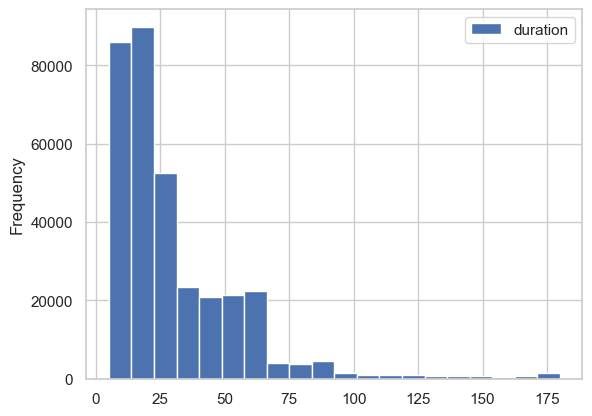

In [13]:
items_meta_df.select("duration").to_pandas().plot.hist(bins=20)

In [14]:
items_meta_df_flatten = (
    items_meta_df
    .with_columns(
        pl.col("duration").cut([25, 60]).to_physical()
    )
    .melt(id_vars=["item_id"], value_vars=["duration"], variable_name="feature", value_name="value")
    .rename({"item_id": "id"})
)

items_meta_df_flatten.sample(3)

id,feature,value
u32,str,u32
70242,"""duration""",1
61817,"""duration""",0
239839,"""duration""",1


# Prepare datasets

In [15]:
def prepare_datasets(interaction_df: pl.DataFrame):
    train_df_pd = interaction_df.to_pandas()
    users_meta_df_flatten_pd = users_meta_df_flatten.to_pandas()
    items_meta_df_flatten_pd = items_meta_df_flatten.to_pandas()
    
    
    dataset_no_features = Dataset.construct(
        interactions_df=train_df_pd,
    )
    
    dataset_full_features = Dataset.construct(
        interactions_df=train_df_pd,
        user_features_df=users_meta_df_flatten_pd,
        cat_user_features=users_meta_df_flatten["feature"].unique().to_list(),
        item_features_df=items_meta_df_flatten_pd,
        cat_item_features=items_meta_df_flatten["feature"].unique().to_list(),
    )
    
    dataset_item_features = Dataset.construct(
        interactions_df=train_df_pd,
        item_features_df=items_meta_df_flatten_pd,
        cat_item_features=items_meta_df_flatten["feature"].unique().to_list(),
    )
    
    dataset_user_features = Dataset.construct(
        interactions_df=train_df_pd,
        user_features_df=users_meta_df_flatten_pd,
        cat_user_features=users_meta_df_flatten["feature"].unique().to_list(),
    )
    
    return {
        "no_features": dataset_no_features,
        "full_features": dataset_full_features,
        "item_features": dataset_item_features,
        "user_features": dataset_user_features
    }


train_feature_datasets = prepare_datasets(train_df)

# Metrics

In [16]:
metrics_name = {
    'MAP': MAP,
    'MIUF': MeanInvUserFreq,
    'Serendipity': Serendipity,
    'HR': HitRate
}


metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (1, 5, 10):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

# Metrics

In [17]:
K_RECOS = 10
NUM_THREADS = 8
RANDOM_STATE = 42
ITERATIONS = 10

In [18]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool=False, iterations: int = ITERATIONS):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=iterations),
        fit_features_together = fit_features_together,
    )

# Grid search 

In [62]:
alphas = [1, 10]
regularizations = [0.01, 0.1]
factors = [64]

In [63]:
# results = []

for dataset_name in (
    "no_features",
    "full_features",
    "item_features",
    "user_features"
):
    dataset = train_feature_datasets[dataset_name]
    for alpha in alphas:
        for regularization in regularizations:
            for n_factors in factors:
                model_name = f"{dataset_name}_{n_factors}_alpha_{alpha}_reg_{regularization}"
                model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
                model.fit(dataset)
                recos = model.recommend(
                    users=test_users,
                    dataset=dataset,
                    k=K_RECOS,
                    filter_viewed=True,
                )
                metric_values = calc_metrics(metrics, recos, test_df.to_pandas(), train_df.to_pandas(), catalog)
                metric_values["model"] = model_name
    
                # rocauc
                user_embeddings, item_embeddings = model.get_vectors()
                user2item_dist = (
                    user_embeddings[dataset.user_id_map.convert_to_internal(test_df["user_id"].to_numpy())]
                    * item_embeddings[dataset.item_id_map.convert_to_internal(test_df["item_id"].to_numpy())]
                ).sum(axis=1)
                
                rocauc = roc_auc_score(
                    test_df["weight"].to_numpy(),
                    user2item_dist
                )
                
                metric_values["rocauc"] = rocauc
                
                results.append(metric_values)
    
                print(model_name, rocauc)
                print("-" * 10 + "\n")

# pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)

no_features_64_alpha_1_reg_0.01 0.8829248977851785
----------

no_features_64_alpha_1_reg_0.1 0.8829697391619187
----------

no_features_64_alpha_10_reg_0.01 0.9058045996257811
----------

no_features_64_alpha_10_reg_0.1 0.9058042046394899
----------



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

full_features_64_alpha_1_reg_0.01 0.8655782048027876
----------



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

full_features_64_alpha_1_reg_0.1 0.8655717439894117
----------



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

full_features_64_alpha_10_reg_0.01 0.8954714466182492
----------



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

full_features_64_alpha_10_reg_0.1 0.8954702424690216
----------



  0%|          | 0/1 [00:00<?, ?it/s]

item_features_64_alpha_1_reg_0.01 0.8942763640866255
----------



  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
pd.DataFrame(results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False).sort_values("rocauc", ascending=False)

,HR@1,HR@5,HR@10,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10,rocauc
model,,,,,,,,,,,,,
item_features_32_alpha_10_reg_0.01,0.029040,0.107835,0.169935,0.003527,0.007206,0.008778,6.698099,6.886251,6.998088,0.000025,0.000026,0.000026,0.912350
item_features_32_alpha_10_reg_0.1,0.029066,0.107835,0.170011,0.003532,0.007207,0.008782,6.698096,6.886440,6.998332,0.000025,0.000026,0.000026,0.912350
item_features_16_alpha_10_reg_0.01,0.025473,0.094435,0.152413,0.003046,0.006142,0.007567,6.519728,6.695870,6.809269,0.000016,0.000017,0.000018,0.908444
item_features_16_alpha_10_reg_0.1,0.025456,0.094435,0.152396,0.003037,0.006131,0.007556,6.520295,6.696270,6.809736,0.000016,0.000017,0.000018,0.908443
no_features_64_alpha_10_reg_0.01,0.030726,0.113114,0.179972,0.003619,0.007473,0.009224,6.803104,6.990611,7.102415,0.000033,0.000034,0.000034,0.905805
no_features_64_alpha_10_reg_0.1,0.030743,0.112960,0.179862,0.003649,0.007488,0.009241,6.802975,6.990556,7.102359,0.000033,0.000034,0.000034,0.905804
no_features_32_alpha_10_reg_0.1,0.029049,0.107733,0.169875,0.003538,0.007196,0.008778,6.687057,6.871437,6.981611,0.000025,0.000026,0.000026,0.905420
no_features_32_alpha_10_reg_0.01,0.029015,0.107716,0.169807,0.003532,0.007195,0.008774,6.686937,6.871412,6.981670,0.000025,0.000026,0.000026,0.905418
item_features_16_alpha_1_reg_0.1,0.023609,0.086730,0.138715,0.002317,0.004978,0.006145,6.245588,6.423850,6.530554,0.000009,0.000011,0.000012,0.903414


In [61]:
pure_df.sort_values("rocauc", ascending=False)

,HR@1,HR@5,HR@10,MAP@1,MAP@5,MAP@10,MIUF@1,MIUF@5,MIUF@10,Serendipity@1,Serendipity@5,Serendipity@10,rocauc,n_features,alpha,reg
model,,,,,,,,,,,,,,,,
item_features_32_alpha_10_reg_0.01,0.029040,0.107835,0.169935,0.003527,0.007206,0.008778,6.698099,6.886251,6.998088,0.000025,0.000026,0.000026,0.912350,32,10.0,0.01
item_features_32_alpha_10_reg_0.1,0.029066,0.107835,0.170011,0.003532,0.007207,0.008782,6.698096,6.886440,6.998332,0.000025,0.000026,0.000026,0.912350,32,10.0,0.10
item_features_16_alpha_10_reg_0.01,0.025473,0.094435,0.152413,0.003046,0.006142,0.007567,6.519728,6.695870,6.809269,0.000016,0.000017,0.000018,0.908444,16,10.0,0.01
item_features_16_alpha_10_reg_0.1,0.025456,0.094435,0.152396,0.003037,0.006131,0.007556,6.520295,6.696270,6.809736,0.000016,0.000017,0.000018,0.908443,16,10.0,0.10
no_features_32_alpha_10_reg_0.1,0.029049,0.107733,0.169875,0.003538,0.007196,0.008778,6.687057,6.871437,6.981611,0.000025,0.000026,0.000026,0.905420,32,10.0,0.10
no_features_32_alpha_10_reg_0.01,0.029015,0.107716,0.169807,0.003532,0.007195,0.008774,6.686937,6.871412,6.981670,0.000025,0.000026,0.000026,0.905418,32,10.0,0.01
item_features_16_alpha_1_reg_0.1,0.023609,0.086730,0.138715,0.002317,0.004978,0.006145,6.245588,6.423850,6.530554,0.000009,0.000011,0.000012,0.903414,16,1.0,0.10
item_features_16_alpha_1_reg_0.01,0.023626,0.086755,0.138655,0.002318,0.004977,0.006143,6.245620,6.423747,6.530383,0.000009,0.000011,0.000012,0.903398,16,1.0,0.01
item_features_32_alpha_1_reg_0.1,0.025090,0.093983,0.148940,0.002590,0.005465,0.006775,6.235051,6.448039,6.568725,0.000011,0.000015,0.000016,0.902294,32,1.0,0.10


In [57]:
pure_df = (
    pure_df
    .reset_index()
    .assign(n_features=lambda x: x.model.map(lambda x: int(re.findall("features_\d{1,}", x)[0].split("_")[1])))
    .assign(alpha=lambda x: x.model.map(lambda x: float(re.findall("alpha_\d{1,}", x)[0].split("_")[1])))
    .assign(reg=lambda x: x.model.map(lambda x: float(re.findall("reg_0\.\d{1,}", x)[0].split("_")[1])))
    .set_index("model")
)

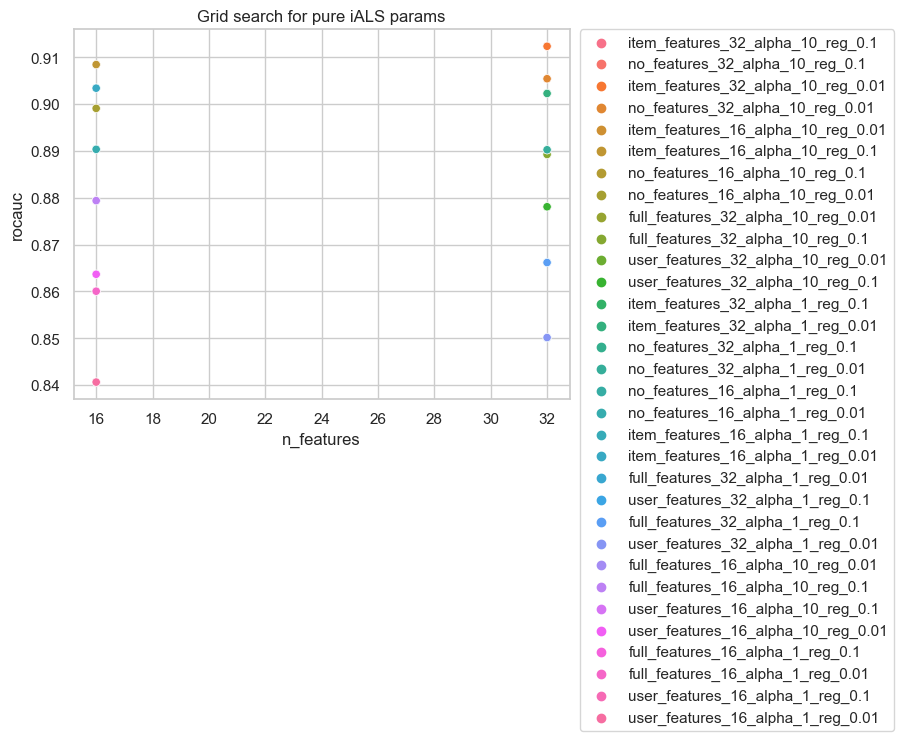

In [60]:
sns.scatterplot(data = pure_df, x="n_features", y="rocauc", hue="model", legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Grid search for pure iALS params")
plt.show()

# Train final

In [27]:
catalog = interactions_df["item_id"].unique().to_numpy()

In [30]:
dataset_name = "item_features"
alpha = 10
regularization = 0.01
n_factors = 64

In [31]:
train_feature_datasets = prepare_datasets(interactions_df.with_columns(pl.lit(0).alias(Columns.Datetime)))

In [32]:
dataset = train_feature_datasets[dataset_name]
model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
model.fit(dataset)
recos = model.recommend(
    users=test_users,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
catalog_item_ids = interactions_df.select(pl.col("item_id").cast(pl.Int64)).unique()
user_item_ids = interactions_df.select(pl.col("user_id").cast(pl.Int64)).unique()

hot_pairs = (
    test_pairs
    .join(catalog_item_ids, how="inner", on="item_id")
    .join(user_item_ids, how="inner", on="user_id")
)

cold_pairs = (
    test_pairs
    .join(hot_pairs, how="anti", on=["item_id", "user_id"])
)

In [42]:
user_embeddings, item_embeddings = model.get_vectors()
user2item_dist = (
    user_embeddings[dataset.user_id_map.convert_to_internal(hot_pairs["user_id"].to_numpy())]
    * item_embeddings[dataset.item_id_map.convert_to_internal(hot_pairs["item_id"].to_numpy())]
).sum(axis=1)

In [57]:
from datetime import datetime

int(datetime.now().timestamp())

1730751564

In [58]:
pl.concat([
    hot_pairs.with_columns(predict=user2item_dist),
    cold_pairs.with_columns(predict=pl.lit(-1.0).cast(pl.Float32)),
]).write_csv(f'../data/submissions/{int(datetime.now().timestamp())}_submission.csv')